In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import seawater as sw
from seawater.library import T90conv
from scipy import stats

#### Get mean ALK control and noGCB over the last IAF cycle for 003 run

In [2]:
years='0249-0310'
case='cesm22cocco.G1850ECOIAF.T62_g17.003'
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK.'+years+'.nc'
cesm_ann_ds = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [3]:
years='0249-0310'
case='cesm22cocco.G1850ECOIAF.T62_g17.003'
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK_ALT_CO2.'+years+'.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ann_ds['ALK_noGCB']=ds_tmp['ALK_ALT_CO2']

### and for the 2x run

In [4]:
years='0249-0310'
case='cesm22cocco.G1850ECOIAF.T62_g17.004'
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK_ALT_CO2.'+years+'.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ann_ds['ALK_2xGCB']=ds_tmp['ALK_ALT_CO2']

In [5]:
cesm_ann_ds = cesm_ann_ds.mean(dim='time')

### other setup

In [6]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [7]:
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2013_POPgrid.nc' 
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)
ds_woa['z_t'] = cesm_ann_ds.z_t

In [8]:
lons=ds_woa.TLONG
lats=ds_woa.TLAT
area=ds_woa.TAREA
depths=ds_woa.z_t * 0.01

In [9]:
dz_m=cesm_ann_ds.dz * 0.01
area_m = area * 1.e-4

## Vertically integrate alkalinity

In [10]:
alk_zint = esmlab.weighted_sum(cesm_ann_ds['ALK'], weights=dz_m, dim=['z_t']).compute()
alk_zint_noGCB = esmlab.weighted_sum(cesm_ann_ds['ALK_noGCB'], weights=dz_m, dim=['z_t']).compute()
alk_zint_2xGCB = esmlab.weighted_sum(cesm_ann_ds['ALK_2xGCB'], weights=dz_m, dim=['z_t']).compute()

In [11]:
alk_zint_noGCBdiff_iaf5 = alk_zint_noGCB - alk_zint
alk_zint_noGCBdiff_iaf5 = alk_zint_noGCBdiff_iaf5 / 1000.

alk_zint_2xGCBdiff_iaf5 = alk_zint_2xGCB - alk_zint
alk_zint_2xGCBdiff_iaf5 = alk_zint_2xGCBdiff_iaf5 / 1000.

#### Shows SO alkalinity trap with vertical integration

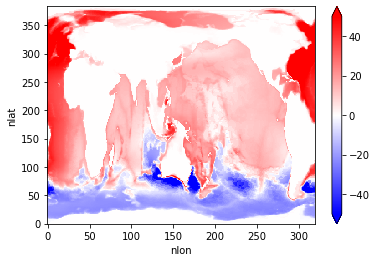

In [12]:
alk_zint_noGCBdiff_iaf5.plot(vmin=-50,vmax=50,cmap='bwr')

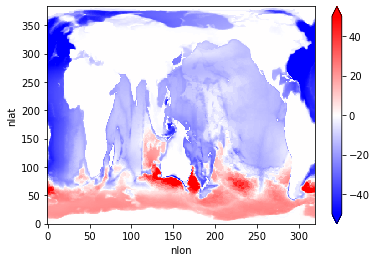

In [13]:
alk_zint_2xGCBdiff_iaf5.plot(vmin=-50,vmax=50,cmap='bwr')

### Look at 4th IAF map

In [14]:
years='0187-0248'
case='cesm22cocco.G1850ECOIAF.T62_g17.003'
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK.'+years+'.nc'
cesm_ann_ds = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [15]:
years='0187-0248'
case='cesm22cocco.G1850ECOIAF.T62_g17.003'
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK_ALT_CO2.'+years+'.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ann_ds['ALK_noGCB']=ds_tmp['ALK_ALT_CO2']

In [16]:
years='0187-0248'
case='cesm22cocco.G1850ECOIAF.T62_g17.004'
file='/glade/scratch/kristenk/archive/'+ case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK_ALT_CO2.'+years+'.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ann_ds['ALK_2xGCB']=ds_tmp['ALK_ALT_CO2']

In [17]:
cesm_ann_ds = cesm_ann_ds.mean(dim='time')

In [18]:
## vertical integration
alk_zint = esmlab.weighted_sum(cesm_ann_ds['ALK'], weights=dz_m, dim=['z_t']).compute()
alk_zint_noGCB = esmlab.weighted_sum(cesm_ann_ds['ALK_noGCB'], weights=dz_m, dim=['z_t']).compute()
alk_zint_2xGCB = esmlab.weighted_sum(cesm_ann_ds['ALK_2xGCB'], weights=dz_m, dim=['z_t']).compute()

In [19]:
alk_zint_noGCBdiff_iaf4 = alk_zint_noGCB - alk_zint
alk_zint_noGCBdiff_iaf4 = alk_zint_noGCBdiff_iaf4 / 1000.

alk_zint_2xGCBdiff_iaf4 = alk_zint_2xGCB - alk_zint
alk_zint_2xGCBdiff_iaf4 = alk_zint_2xGCBdiff_iaf4 / 1000.

### 3rd IAF

In [20]:
years='0125-0186'

In [21]:
case='cesm22cocco.G1850ECOIAF.T62_g17.003'
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK.'+years+'.nc'
cesm_ann_ds = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [22]:
case='cesm22cocco.G1850ECOIAF.T62_g17.003'
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK_ALT_CO2.'+years+'.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ann_ds['ALK_noGCB']=ds_tmp['ALK_ALT_CO2']

In [23]:
case='cesm22cocco.G1850ECOIAF.T62_g17.004'
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK_ALT_CO2.'+years+'.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ann_ds['ALK_2xGCB']=ds_tmp['ALK_ALT_CO2']

In [24]:
cesm_ann_ds = cesm_ann_ds.mean(dim='time')

In [25]:
## vertical integration
alk_zint = esmlab.weighted_sum(cesm_ann_ds['ALK'], weights=dz_m, dim=['z_t']).compute()
alk_zint_noGCB = esmlab.weighted_sum(cesm_ann_ds['ALK_noGCB'], weights=dz_m, dim=['z_t']).compute()
alk_zint_2xGCB = esmlab.weighted_sum(cesm_ann_ds['ALK_2xGCB'], weights=dz_m, dim=['z_t']).compute()

In [26]:
alk_zint_noGCBdiff_iaf3 = alk_zint_noGCB - alk_zint
alk_zint_noGCBdiff_iaf3 = alk_zint_noGCBdiff_iaf3 / 1000.

alk_zint_2xGCBdiff_iaf3 = alk_zint_2xGCB - alk_zint
alk_zint_2xGCBdiff_iaf3 = alk_zint_2xGCBdiff_iaf3 / 1000.

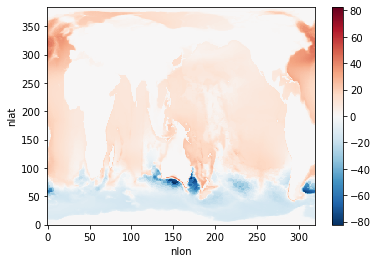

In [27]:
alk_zint_noGCBdiff_iaf3.plot()

### 2nd IAF

In [28]:
years='0063-0124'

In [29]:
case='cesm22cocco.G1850ECOIAF.T62_g17.003'
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK.'+years+'.nc'
cesm_ann_ds = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [30]:
case='cesm22cocco.G1850ECOIAF.T62_g17.003'
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK_ALT_CO2.'+years+'.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ann_ds['ALK_noGCB']=ds_tmp['ALK_ALT_CO2']

In [31]:
case='cesm22cocco.G1850ECOIAF.T62_g17.004'
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK_ALT_CO2.'+years+'.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ann_ds['ALK_2xGCB']=ds_tmp['ALK_ALT_CO2']

In [32]:
cesm_ann_ds = cesm_ann_ds.mean(dim='time')

In [33]:
## vertical integration
alk_zint = esmlab.weighted_sum(cesm_ann_ds['ALK'], weights=dz_m, dim=['z_t']).compute()
alk_zint_noGCB = esmlab.weighted_sum(cesm_ann_ds['ALK_noGCB'], weights=dz_m, dim=['z_t']).compute()
alk_zint_2xGCB = esmlab.weighted_sum(cesm_ann_ds['ALK_2xGCB'], weights=dz_m, dim=['z_t']).compute()

In [34]:
alk_zint_noGCBdiff_iaf2 = alk_zint_noGCB - alk_zint
alk_zint_noGCBdiff_iaf2 = alk_zint_noGCBdiff_iaf2 / 1000.

alk_zint_2xGCBdiff_iaf2 = alk_zint_2xGCB - alk_zint
alk_zint_2xGCBdiff_iaf2 = alk_zint_2xGCBdiff_iaf2 / 1000.

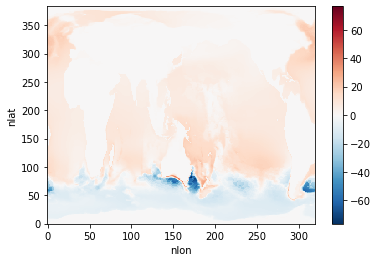

In [35]:
alk_zint_noGCBdiff_iaf2.plot()

### first IAF

In [36]:
years='0001-0062'

In [37]:
case='cesm22cocco.G1850ECOIAF.T62_g17.003'
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK.'+years+'.nc'
cesm_ann_ds = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [38]:
case='cesm22cocco.G1850ECOIAF.T62_g17.003'
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK_ALT_CO2.'+years+'.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ann_ds['ALK_noGCB']=ds_tmp['ALK_ALT_CO2']

In [39]:
case='cesm22cocco.G1850ECOIAF.T62_g17.004'
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.ALK_ALT_CO2.'+years+'.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ann_ds['ALK_2xGCB']=ds_tmp['ALK_ALT_CO2']

In [40]:
cesm_ann_ds = cesm_ann_ds.mean(dim='time')

In [41]:
## vertical integration
alk_zint = esmlab.weighted_sum(cesm_ann_ds['ALK'], weights=dz_m, dim=['z_t']).compute()
alk_zint_noGCB = esmlab.weighted_sum(cesm_ann_ds['ALK_noGCB'], weights=dz_m, dim=['z_t']).compute()
alk_zint_2xGCB = esmlab.weighted_sum(cesm_ann_ds['ALK_2xGCB'], weights=dz_m, dim=['z_t']).compute()

In [42]:
alk_zint_noGCBdiff_iaf1 = alk_zint_noGCB - alk_zint
alk_zint_noGCBdiff_iaf1 = alk_zint_noGCBdiff_iaf1 / 1000.

alk_zint_2xGCBdiff_iaf1 = alk_zint_2xGCB - alk_zint
alk_zint_2xGCBdiff_iaf1 = alk_zint_2xGCBdiff_iaf1 / 1000.

### Make a 2x10 figure of plots

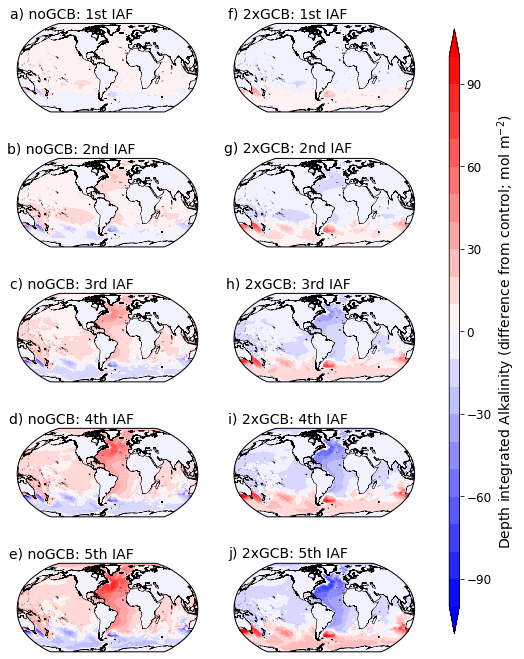

In [46]:
 fig = plt.figure(figsize=(9.6,12))
contour_specs = {'levels': [-100,-90,-80,-70,-60,-50,-40,-30,-20,-10,0.,10,20,30,40,50,60,70,80,90,100,]}

#plt.suptitle('Vertically integrated difference in alkalinity',fontsize=14)
#######################

ax = fig.add_subplot(5,2,1, projection=ccrs.Robinson(central_longitude=305.0))
lon,lat,field = adjust_pop_grid(lons,lats,alk_zint_noGCBdiff_iaf1)
ax.set_title('a) noGCB: 1st IAF', x=0.3,fontsize=14)
cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='bwr',extend='both',**contour_specs)
ax.coastlines('10m',linewidth=0.5)

ax = fig.add_subplot(5,2,2, projection=ccrs.Robinson(central_longitude=305.0))
lon,lat,field = adjust_pop_grid(lons,lats,alk_zint_2xGCBdiff_iaf1)
ax.set_title('f) 2xGCB: 1st IAF', x=0.3, fontsize=14)
cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='bwr',extend='both',**contour_specs)
ax.coastlines('10m',linewidth=0.5)
#####################

ax = fig.add_subplot(5,2,3, projection=ccrs.Robinson(central_longitude=305.0))
lon,lat,field = adjust_pop_grid(lons,lats,alk_zint_noGCBdiff_iaf2)
ax.set_title('b) noGCB: 2nd IAF', x=0.3,fontsize=14)
cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='bwr',extend='both',**contour_specs)
ax.coastlines('10m',linewidth=0.5)

ax = fig.add_subplot(5,2,4, projection=ccrs.Robinson(central_longitude=305.0))
lon,lat,field = adjust_pop_grid(lons,lats,alk_zint_2xGCBdiff_iaf2)
ax.set_title('g) 2xGCB: 2nd IAF', x=0.3, fontsize=14)
cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='bwr',extend='both',**contour_specs)
ax.coastlines('10m',linewidth=0.5)
#####################

ax = fig.add_subplot(5,2,5, projection=ccrs.Robinson(central_longitude=305.0))
lon,lat,field = adjust_pop_grid(lons,lats,alk_zint_noGCBdiff_iaf3)
ax.set_title('c) noGCB: 3rd IAF', x=0.3,fontsize=14)
cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='bwr',extend='both',**contour_specs)
ax.coastlines('10m',linewidth=0.5)

ax = fig.add_subplot(5,2,6, projection=ccrs.Robinson(central_longitude=305.0))
lon,lat,field = adjust_pop_grid(lons,lats,alk_zint_2xGCBdiff_iaf3)
ax.set_title('h) 2xGCB: 3rd IAF', x=0.3, fontsize=14)
cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='bwr',extend='both',**contour_specs)
ax.coastlines('10m',linewidth=0.5)
#####################



ax = fig.add_subplot(5,2,7, projection=ccrs.Robinson(central_longitude=305.0))
lon,lat,field = adjust_pop_grid(lons,lats,alk_zint_noGCBdiff_iaf4)
ax.set_title('d) noGCB: 4th IAF', x=0.3,fontsize=14)
cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='bwr',extend='both',**contour_specs)
ax.coastlines('10m',linewidth=0.5)

ax = fig.add_subplot(5,2,8, projection=ccrs.Robinson(central_longitude=305.0))
lon,lat,field = adjust_pop_grid(lons,lats,alk_zint_2xGCBdiff_iaf4)
ax.set_title('i) 2xGCB: 4th IAF', x=0.3, fontsize=14)
cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='bwr',extend='both',**contour_specs)
ax.coastlines('10m',linewidth=0.5)
#####################

ax = fig.add_subplot(5,2,9, projection=ccrs.Robinson(central_longitude=305.0))
lon,lat,field = adjust_pop_grid(lons,lats,alk_zint_noGCBdiff_iaf5)
ax.set_title('e) noGCB: 5th IAF', x=0.3,fontsize=14)
cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='bwr',extend='both',**contour_specs)
ax.coastlines('10m',linewidth=0.5)

ax = fig.add_subplot(5,2,10, projection=ccrs.Robinson(central_longitude=305.0))
lon,lat,field = adjust_pop_grid(lons,lats,alk_zint_2xGCBdiff_iaf5)
ax.set_title('j) 2xGCB: 5th IAF', x=0.3, fontsize=14)
cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='bwr',extend='both',**contour_specs)
ax.coastlines('10m',linewidth=0.5)
#####################








fig.subplots_adjust(right=0.7,wspace=0.2)
cbar_ax = fig.add_axes([0.75, 0.16, 0.015, 0.7])
cbar = fig.colorbar(cf, cax=cbar_ax,extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='Depth integrated Alkalinity (difference from control; mol m$^{-2}$)', size=14)
fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/Alk_zint_diff_maps_all_IAFs.pdf', bbox_inches='tight', format='pdf');


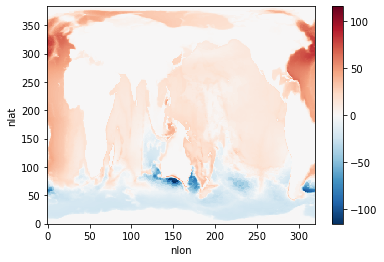

In [54]:
alk_zint_noGCBdiff_iaf5.plot()

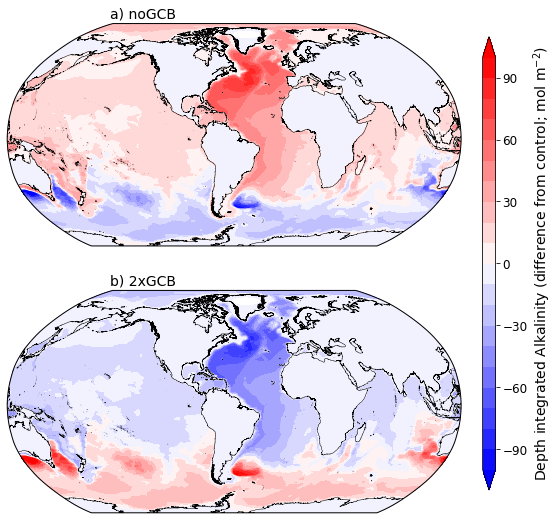

In [56]:
 fig = plt.figure(figsize=(12,9))
contour_specs = {'levels': [-100,-90,-80,-70,-60,-50,-40,-30,-20,-10,0.,10,20,30,40,50,60,70,80,90,100,]}

#plt.suptitle('Vertically integrated difference in alkalinity',fontsize=14)

ax = fig.add_subplot(2,1,1, projection=ccrs.Robinson(central_longitude=305.0))
lon,lat,field = adjust_pop_grid(lons,lats,alk_zint_noGCBdiff_iaf5)
ax.set_title('a) noGCB', x=0.3,fontsize=14)
cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='bwr',extend='both',**contour_specs)
ax.coastlines('10m',linewidth=0.5)

ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
lon,lat,field = adjust_pop_grid(lons,lats,alk_zint_2xGCBdiff_iaf5)
ax.set_title('b) 2xGCB', x=0.3, fontsize=14)
cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='bwr',extend='both',**contour_specs)
ax.coastlines('10m',linewidth=0.5)

fig.subplots_adjust(right=0.8,wspace=0.2)
cbar_ax = fig.add_axes([0.75, 0.16, 0.015, 0.7])
cbar = fig.colorbar(cf, cax=cbar_ax,extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='Depth integrated Alkalinity (difference from control; mol m$^{-2}$)', size=14)
#fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/Alk_zint_diff_maps.pdf', bbox_inches='tight', format='pdf');
